# 0. Importation des modules et données

In [ ]:
# math modules
import numpy as np
import pandas as pd
from scipy.stats import norm, shapiro

# model mudules
import xgboost as xgb
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor

# utility modules
import warnings
from sklearn.exceptions import DataConversionWarning
from sklearn.metrics import make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
import optuna

# visualization modules
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# data importation
X_train = pd.read_csv("X_train_Wwou3IE.csv")
y_train = pd.read_csv("y_train_jJtXgMX.csv")
X_test = pd.read_csv("X_test_GgyECq8.csv")
y_random_submit = pd.read_csv("y_random_pt8afo8.csv")

# date transformation
X_train['DELIVERY_START'] = pd.to_datetime(X_train['DELIVERY_START'], utc=True)
X_test['DELIVERY_START'] = pd.to_datetime(X_test['DELIVERY_START'], utc=True)

X_train['hour'] = X_train['DELIVERY_START'].dt.hour
X_train['day'] = X_train['DELIVERY_START'].dt.day
X_train['month'] = X_train['DELIVERY_START'].dt.month
X_train['year'] = X_train['DELIVERY_START'].dt.year

X_test['hour'] = X_test['DELIVERY_START'].dt.hour
X_test['day'] = X_test['DELIVERY_START'].dt.day
X_test['month'] = X_test['DELIVERY_START'].dt.month
X_test['year'] = X_test['DELIVERY_START'].dt.year

# 1. Description et visualisation des données

In [3]:
print(f"La dimension de X_train est: {X_train.shape}")
print(f"La dimension de y_train est: {y_train.shape}")
print(f"La dimension de X_test est: {X_test.shape}")
print(f"La dimension de y_test est: {y_random_submit.shape}")
print("\n")
print(f"les données de X_train commencent le {str(X_train['DELIVERY_START'][0])[0:16]} et finissent le {str(X_train['DELIVERY_START'][X_train.shape[0] - 1])[0:16]}")
print(f"les données de X_test commencent le {str(X_test['DELIVERY_START'][0])[0:16]} et finissent le {str(X_test['DELIVERY_START'][X_test.shape[0] - 1])[0:16]}")
print("\n")
print(f"les colonnes de X sont: {X_train.columns.values}\net celles de y: {y_train.columns.values}")

La dimension de X_train est: (10605, 14)
La dimension de y_train est: (10605, 2)
La dimension de X_test est: (4942, 14)
La dimension de y_test est: (4942, 2)


les données de X_train commencent le 2022-01-01 01:00 et finissent le 2023-03-29 21:00
les données de X_test commencent le 2023-04-01 22:00 et finissent le 2023-10-24 21:00


les colonnes de X sont: ['DELIVERY_START' 'load_forecast' 'coal_power_available'
 'gas_power_available' 'nucelear_power_available'
 'wind_power_forecasts_average' 'solar_power_forecasts_average'
 'wind_power_forecasts_std' 'solar_power_forecasts_std'
 'predicted_spot_price' 'hour' 'day' 'month' 'year']
et celles de y: ['DELIVERY_START' 'spot_id_delta']


In [4]:
X_train.head(10)

,DELIVERY_START,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price,hour,day,month,year
0,2022-01-01 01:00:00+00:00,49439.0,3386.0,11487.0,44118.0,3035.0,0.0,79.248348,0.000000,NaN,1,1,1,2022
1,2022-01-01 02:00:00+00:00,46511.0,3386.0,11487.0,44118.0,3143.0,0.0,61.776532,0.000000,NaN,2,1,1,2022
2,2022-01-01 03:00:00+00:00,45158.0,3386.0,11487.0,44118.0,3288.0,0.0,44.291112,0.000000,NaN,3,1,1,2022
3,2022-01-01 04:00:00+00:00,44779.0,3386.0,11487.0,44118.0,3447.0,0.0,36.127588,0.000000,NaN,4,1,1,2022
4,2022-01-01 05:00:00+00:00,45284.0,3386.0,11487.0,44118.0,3679.0,0.0,30.983023,0.000000,NaN,5,1,1,2022
5,2022-01-01 06:00:00+00:00,45648.0,3386.0,11487.0,44118.0,3902.0,0.0,27.624052,0.000000,NaN,6,1,1,2022
6,2022-01-01 07:00:00+00:00,45909.0,3386.0,11487.0,44118.0,4092.0,198.0,44.944701,6.195349,NaN,7,1,1,2022
7,2022-01-01 08:00:00+00:00,47091.0,3386.0,11487.0,44118.0,4315.0,1012.0,30.505330,23.239957,NaN,8,1,1,2022
8,2022-01-01 09:00:00+00:00,48300.0,3386.0,11487.0,44118.0,4436.0,2401.0,35.835910,44.450154,NaN,9,1,1,2022
9,2022-01-01 10:00:00+00:00,49559.0,3386.0,11487.0,44118.0,4459.0,3699.0,57.670945,53.426489,NaN,10,1,1,2022


In [5]:
X_train.isna().sum()

DELIVERY_START                      0
load_forecast                    1287
coal_power_available                1
gas_power_available                 1
nucelear_power_available            1
wind_power_forecasts_average       24
solar_power_forecasts_average      24
wind_power_forecasts_std           24
solar_power_forecasts_std          24
predicted_spot_price             8759
hour                                0
day                                 0
month                               0
year                                0
dtype: int64

In [6]:
X_test.isna().sum()

DELIVERY_START                      0
load_forecast                       0
coal_power_available                0
gas_power_available                 0
nucelear_power_available            0
wind_power_forecasts_average        0
solar_power_forecasts_average      24
wind_power_forecasts_std            0
solar_power_forecasts_std          24
predicted_spot_price             1536
hour                                0
day                                 0
month                               0
year                                0
dtype: int64

C:\Users\asola\AppData\Local\Temp\ipykernel_11280\4276882732.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axs[2, 2], x=last_row.index, y=last_row.values, palette=colors)
C:\Users\asola\AppData\Local\Temp\ipykernel_11280\4276882732.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2, 2].set_xticklabels(Index, rotation=60)


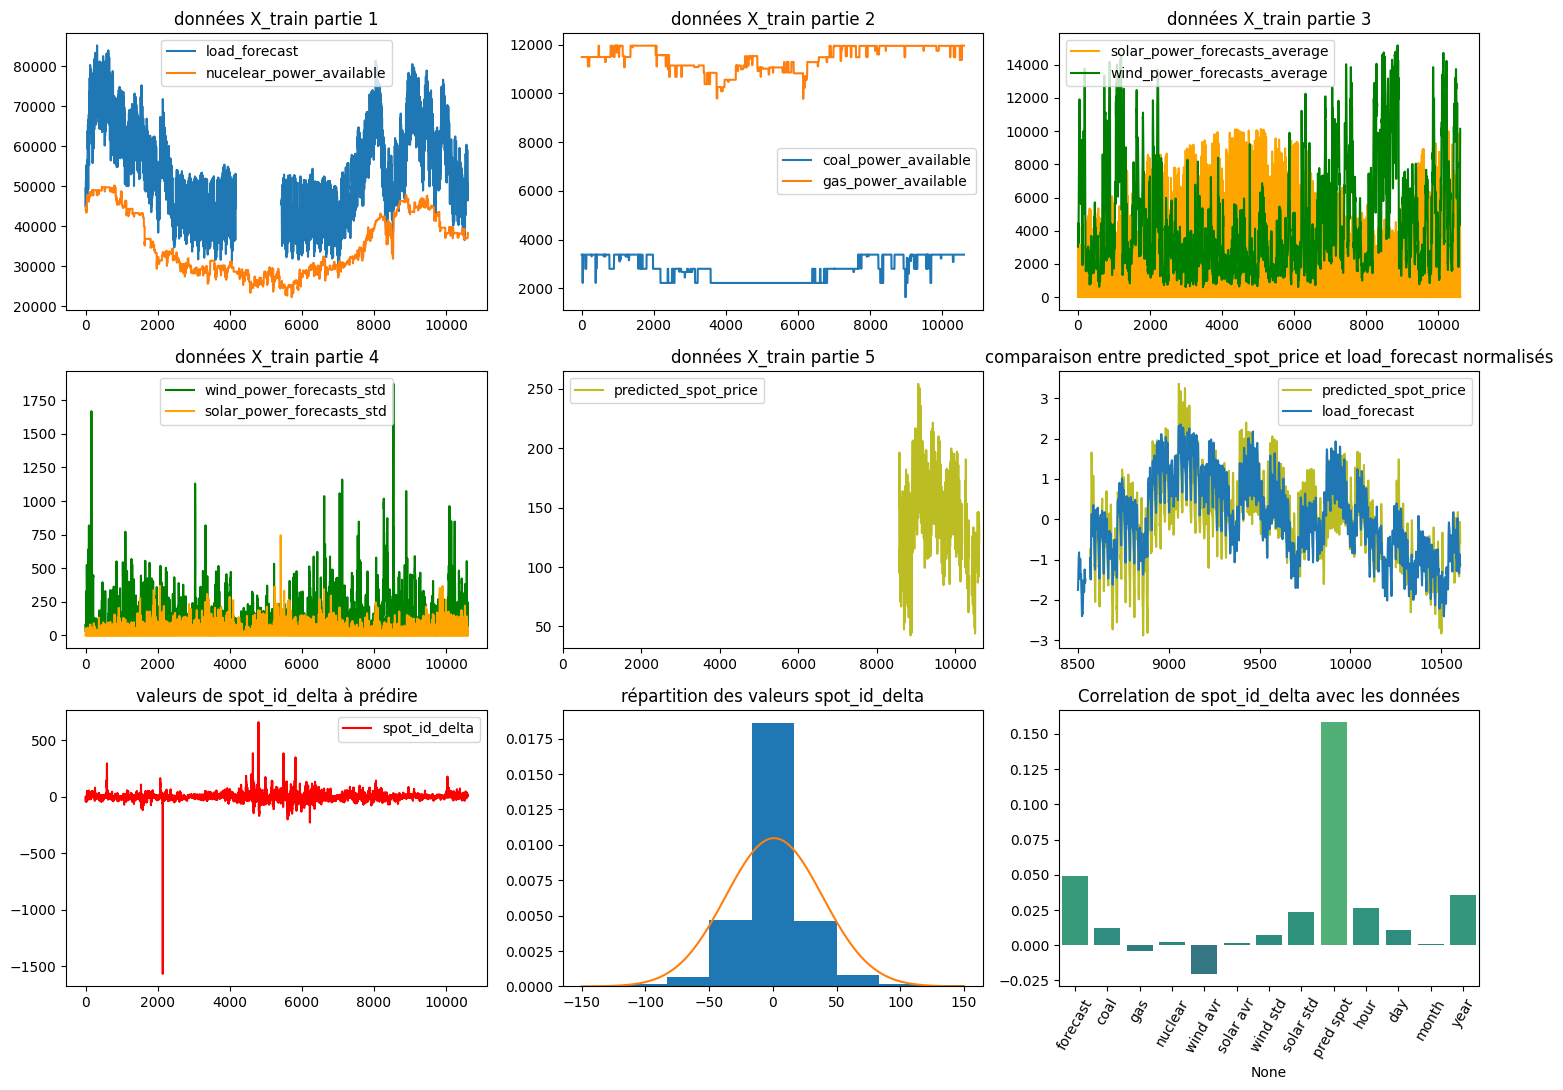

In [7]:
fig, axs = plt.subplots(3, 3, figsize=(15, 11))

# Graphique 1
axs[0, 0].plot(X_train["load_forecast"].values, label="load_forecast", color='tab:blue')
axs[0, 0].plot(X_train["nucelear_power_available"], label="nucelear_power_available", color='tab:orange')
axs[0, 0].set_title("données X_train partie 1")
axs[0, 0].legend()

# Graphique 2
axs[0, 1].plot(X_train["coal_power_available"], label="coal_power_available")
axs[0, 1].plot(X_train["gas_power_available"], label="gas_power_available")
axs[0, 1].set_title("données X_train partie 2")
axs[0, 1].legend()

# Graphique 3
axs[0, 2].plot(X_train["solar_power_forecasts_average"], label="solar_power_forecasts_average", color="orange")
axs[0, 2].plot(X_train["wind_power_forecasts_average"], label="wind_power_forecasts_average", color="green")
axs[0, 2].set_title("données X_train partie 3")
axs[0, 2].legend()

# Graphique 4
axs[1, 0].plot(X_train["wind_power_forecasts_std"], label="wind_power_forecasts_std", color="green")
axs[1, 0].plot(X_train["solar_power_forecasts_std"], label="solar_power_forecasts_std", color="orange")
axs[1, 0].set_title("données X_train partie 4")
axs[1, 0].legend()

# Graphique 5 - Nouveau graphique ajouté
axs[1, 1].plot(X_train["predicted_spot_price"], label="predicted_spot_price", color='tab:olive')
axs[1, 1].set_xticks([0, 2000, 4000, 6000, 8000, 10000])
axs[1, 1].set_title("données X_train partie 5")
axs[1, 1].legend()

# Graphique 6 - Graphique précédent décalé
axs[1, 2].plot((X_train["predicted_spot_price"] - X_train["predicted_spot_price"].mean()) / X_train["predicted_spot_price"].std(), label="predicted_spot_price", color='tab:olive')
axs[1, 2].plot((X_train.loc[8500:, "load_forecast"] - X_train.loc[8500:, "load_forecast"].mean()) / X_train.loc[8500:, "load_forecast"].std(), label="load_forecast", color='tab:blue')
axs[1, 2].set_title("comparaison entre predicted_spot_price et load_forecast normalisés")
axs[1, 2].legend()

# Graphique 7
axs[2, 0].plot(y_train["spot_id_delta"], label="spot_id_delta", color='r')
axs[2, 0].set_title("valeurs de spot_id_delta à prédire")
axs[2, 0].legend()

# Graphique 8
mean = round(y_train["spot_id_delta"].mean(), 2)
std = round(y_train["spot_id_delta"].std(), 2)

x = np.linspace(-150, 150, 1000)
y = norm.pdf(x, mean, std)

axs[2, 1].hist(y_train["spot_id_delta"], bins=9, range=(-150, 150), density=True)
axs[2, 1].plot(x, y)
axs[2, 1].set_title("répartition des valeurs spot_id_delta")

# Graphique 9
combined_df = pd.concat([X_train.copy().drop(columns="DELIVERY_START"), y_train["spot_id_delta"]], axis=1)
correlation_matrix = combined_df.corr()
last_row = correlation_matrix.iloc[-1, :-1]
Index = ["forecast", "coal", "gas", "nuclear", "wind avr", "solar avr", "wind std", "solar std", "pred spot", "hour", "day", "month", "year"]
adjusted_values = np.sign(last_row.values) * (np.abs(last_row.values) ** 0.5)
cmap = plt.cm.viridis
colors = [matplotlib.colors.to_hex(cmap((val + 1) / 2)) for val in adjusted_values]

sns.barplot(ax=axs[2, 2], x=last_row.index, y=last_row.values, palette=colors)
axs[2, 2].set_xticklabels(Index, rotation=60)
axs[2, 2].set_title("Correlation de spot_id_delta avec les données")

# Ajustements
plt.tight_layout()  # Ajuste l'espacement entre les sous-graphiques
plt.show()

In [8]:
X_train = X_train.copy().drop(columns="DELIVERY_START")
y_train = y_train.copy().drop(columns="DELIVERY_START")
X_test = X_test.copy().drop(columns="DELIVERY_START")

# 2. Test de gaussianité

y positif

Shapiro-Wilk test for column 1: p-value = 1.0
Shapiro-Wilk test for column 2: p-value = 0.0
Shapiro-Wilk test for column 3: p-value = 0.0
Shapiro-Wilk test for column 4: p-value = 0.0
Shapiro-Wilk test for column 5: p-value = 1.0
Shapiro-Wilk test for column 6: p-value = 1.0
Shapiro-Wilk test for column 7: p-value = 1.0
Shapiro-Wilk test for column 8: p-value = 1.0
Shapiro-Wilk test for column 9: p-value = 1.0
Shapiro-Wilk test for column 10: p-value = 1.8965019273340999e-38
Shapiro-Wilk test for column 11: p-value = 2.8062584654849763e-37
Shapiro-Wilk test for column 12: p-value = 0.0
Shapiro-Wilk test for column 13: p-value = 0.0

y négatif

Shapiro-Wilk test for column 1: p-value = 1.0
Shapiro-Wilk test for column 2: p-value = 0.0
Shapiro-Wilk test for column 3: p-value = 0.0
Shapiro-Wilk test for column 4: p-value = 0.0
Shapiro-Wilk test for column 5: p-value = 1.0
Shapiro-Wilk test for column 6: p-value = 1.0
Shapiro-Wilk test for column 7: p-value = 1.0
Shapiro-Wilk te

c:\Users\asola\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


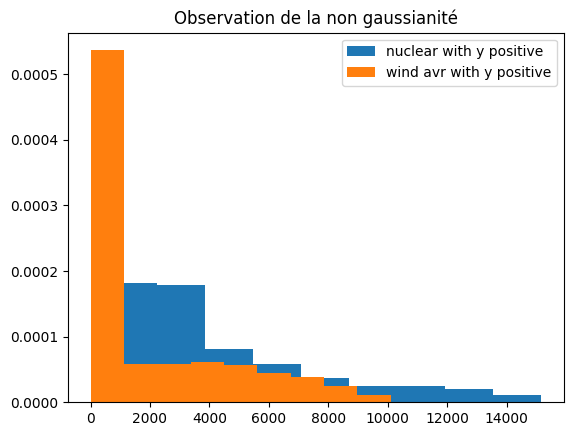

In [9]:
def separation(X, y):
    X_sachant_y_positif = []
    X_sachant_y_negatif = []

    for i in range(len(X)):
        if y["spot_id_delta"][i] >= 0:
            X_sachant_y_positif.append(X.loc[i].values)
        else:
            X_sachant_y_negatif.append(X.loc[i].values)
        
    return np.array(X_sachant_y_positif), np.array(X_sachant_y_negatif)

X_sachant_y_positif, X_sachant_y_negatif = separation(X_train, y_train)

print("y positif\n")

for i in range(X_sachant_y_positif.shape[1]):
    stat, p_value = shapiro(X_sachant_y_positif[:, i])
    print(f"Shapiro-Wilk test for column {i+1}: p-value = {p_value}")

print("\ny négatif\n")

for i in range(X_sachant_y_negatif.shape[1]):
    stat, p_value = shapiro(X_sachant_y_positif[:, i])
    print(f"Shapiro-Wilk test for column {i+1}: p-value = {p_value}")
    
plt.hist(X_sachant_y_positif[:, 4], bins=9, density=True, label="nuclear with y positive")
plt.hist(X_sachant_y_positif[:, 5], bins=9, density=True, label="wind avr with y positive")
plt.title("Observation de la non gaussianité")
plt.legend()
plt.show()

# 3. définition des métriques

In [10]:
def weighted_accuracy(y_true, y_pred):
    
    y_true = y_true.values
    correct_pred = np.array([np.sign(y_pred[i]) == np.sign(y_true[i]) for i in range(len(y_true))])
    abs_y_true = abs(y_true)
    
    return np.sum(correct_pred * abs_y_true) / np.sum(abs_y_true)

weighted_accuracy_scorer = make_scorer(weighted_accuracy, greater_is_better=True)

# 4. Approche naïve

## 1) XGBoost Regressor

In [11]:
warnings.filterwarnings("ignore", category=RuntimeWarning)

model = xgb.XGBRegressor()
pipeline = make_pipeline(StandardScaler(), model)

cv_10_scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring=weighted_accuracy_scorer).round(4)
print(f"10 cv scores: {cv_10_scores}")

mean_cv_10_score = cv_10_scores.mean().round(4)
print("Mean Cross-Validation Weighted Accuracy:", mean_cv_10_score)



k = 10
tscv = TimeSeriesSplit(n_splits=k)

tscv_scores = cross_val_score(pipeline, X_train, y_train, cv=tscv, scoring=weighted_accuracy_scorer).round(4)
print(f"\ntscv scores: {tscv_scores}")

mean_tscv_score = tscv_scores.mean().round(4)
print("Mean Cross-Validation Weighted Accuracy:", mean_tscv_score)



pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_train)

test_weighted_accuracy = round(weighted_accuracy(y_train, predictions), 4)
print("\nOverfitted Weighted Accuracy:", test_weighted_accuracy)

y_test_pred = pipeline.predict(X_test)

10 cv scores: [0.5913 0.4742 0.4345 0.4515 0.5907 0.589  0.5515 0.4677 0.4916 0.5475]
Mean Cross-Validation Weighted Accuracy: 0.519

tscv scores: [0.5931 0.5676 0.5085 0.4599 0.5552 0.5169 0.4997 0.4664 0.405  0.5107]
Mean Cross-Validation Weighted Accuracy: 0.5083

Overfitted Weighted Accuracy: 0.9574


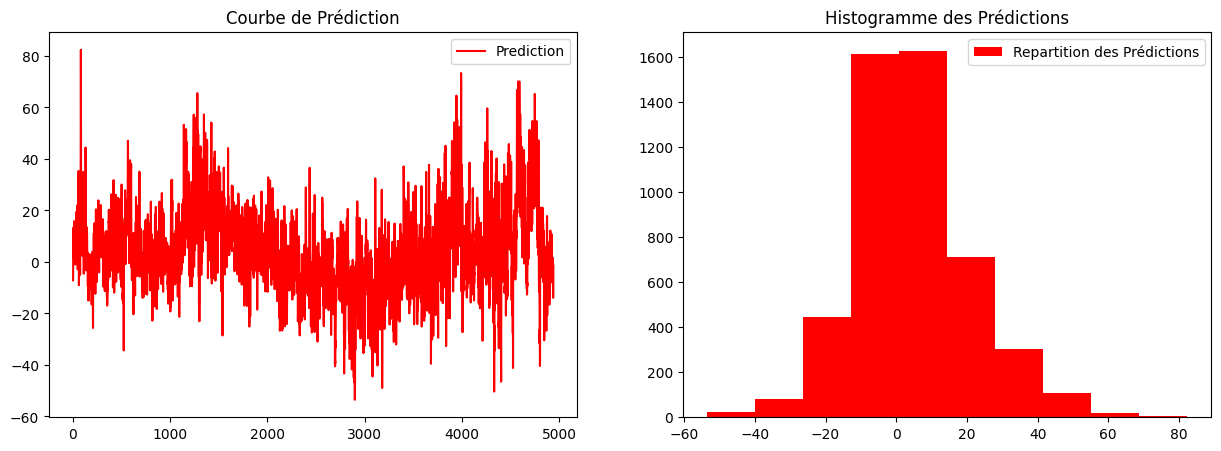

In [81]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(y_test_pred, label="Prediction", color='r')
axs[0].set_title("Courbe de Prédiction")
axs[0].legend()

axs[1].hist(y_test_pred, label="Repartition des Prédictions", color='r')
axs[1].set_title("Histogramme des Prédictions")
axs[1].legend()

plt.show()

# 0,5458

### Optimisation bayésienne des hyper-paramètres (cv=10)

In [82]:
def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 100, 200)  # Increased range
    max_depth = trial.suggest_int('max_depth', 4, 5)  # Extended depth
    learning_rate = trial.suggest_float('learning_rate', 0.02, 0.03)  # Broader range
    subsample = trial.suggest_float('subsample', 0.8, 1.0)  # Lower bound for more randomness
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.8, 1.0)  # Lower bound for feature sampling
    min_child_weight = trial.suggest_int('min_child_weight', 1, 3)  # Adjust based on your data
    reg_alpha = trial.suggest_float('reg_alpha', 0.0, 0.5)  # L1 regularization
    reg_lambda = trial.suggest_float('reg_lambda', 1e-3, 0.5)  # L2 regularization
    gamma = trial.suggest_float('gamma', 3, 5)  # Minimum loss reduction

    
    model = xgb.XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        min_child_weight=min_child_weight,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        gamma=gamma,
        tree_method='hist',
        verbosity=0 
    )

    
    pipeline = make_pipeline(StandardScaler(), model)
    score = cross_val_score(pipeline, X_train, y_train, cv=10, scoring=weighted_accuracy_scorer).mean()

    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)


print("Best parameters:", study.best_params)
print("Best cross-validation score:", study.best_value)

[I 2024-11-10 16:06:26,956] A new study created in memory with name: no-name-7b5cb0a6-22f5-447d-b1b5-fae5c4dbcef5
[I 2024-11-10 16:06:28,338] Trial 0 finished with value: 0.5295318385295906 and parameters: {'n_estimators': 154, 'max_depth': 5, 'learning_rate': 0.021579067130314003, 'subsample': 0.993689464254692, 'colsample_bytree': 0.9997210146668003, 'min_child_weight': 3, 'reg_alpha': 0.43805075564275825, 'reg_lambda': 0.2518529533084616, 'gamma': 3.7632602804513127}. Best is trial 0 with value: 0.5295318385295906.
[I 2024-11-10 16:06:29,474] Trial 1 finished with value: 0.5188468860846644 and parameters: {'n_estimators': 165, 'max_depth': 4, 'learning_rate': 0.02758936977692795, 'subsample': 0.8103478899769136, 'colsample_bytree': 0.8644433157206189, 'min_child_weight': 3, 'reg_alpha': 0.20175951396936703, 'reg_lambda': 0.41370877313797755, 'gamma': 3.4535598225268638}. Best is trial 0 with value: 0.5295318385295906.
[I 2024-11-10 16:06:30,638] Trial 2 finished with value: 0.543785

Best parameters: {'n_estimators': 177, 'max_depth': 4, 'learning_rate': 0.02335596796928802, 'subsample': 0.9143065576230869, 'colsample_bytree': 0.9321714952941054, 'min_child_weight': 1, 'reg_alpha': 0.2467638628160313, 'reg_lambda': 0.09276650893649153, 'gamma': 4.44273263641691}
Best cross-validation score: 0.5549328527842168


In [83]:
optuna.visualization.plot_param_importances(study)

In [84]:
optuna.visualization.plot_optimization_history(study)

In [85]:
optuna.visualization.plot_slice(study)

Best parameters: {'n_estimators': 177, 'max_depth': 4, 'learning_rate': 0.02335596796928802, 'subsample': 0.9143065576230869, 'colsample_bytree': 0.9321714952941054, 'min_child_weight': 1, 'reg_alpha': 0.2467638628160313, 'reg_lambda': 0.09276650893649153, 'gamma': 4.44273263641691}
Best cross-validation score: 0.5549328527842168

In [92]:
warnings.filterwarnings("ignore", category=RuntimeWarning)

model = xgb.XGBRegressor(n_estimators = 177, max_depth = 4, learning_rate = 0.02335596796928802, subsample = 0.9143065576230869, colsample_bytree = 0.9321714952941054, 
                         min_child_weight = 1, reg_alpha = 0.2467638628160313, reg_lambda = 0.09276650893649153, gamma = 4.44273263641691)
pipeline = make_pipeline(StandardScaler(), model)

cv_10_scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring=weighted_accuracy_scorer).round(4)
print(f"10 cv scores: {cv_10_scores}")

mean_cv_10_score = cv_10_scores.mean().round(4)
print("Mean Cross-Validation Weighted Accuracy:", mean_cv_10_score)



k = 10
tscv = TimeSeriesSplit(n_splits=k)

tscv_scores = cross_val_score(pipeline, X_train, y_train, cv=tscv, scoring=weighted_accuracy_scorer).round(4)
print(f"\ntscv scores: {tscv_scores}")

mean_tscv_score = tscv_scores.mean().round(4)
print("Mean Cross-Validation Weighted Accuracy:", mean_tscv_score)



pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_train)

test_weighted_accuracy = round(weighted_accuracy(y_train, predictions), 4)
print("\nOverfitted Weighted Accuracy:", test_weighted_accuracy)

y_test_pred = pipeline.predict(X_test)

10 cv scores: [0.6577 0.4031 0.3911 0.4874 0.642  0.5696 0.6209 0.5793 0.6205 0.5776]
Mean Cross-Validation Weighted Accuracy: 0.5549

tscv scores: [0.5662 0.5403 0.3987 0.431  0.6208 0.5124 0.4489 0.5688 0.4707 0.5752]
Mean Cross-Validation Weighted Accuracy: 0.5133

Overfitted Weighted Accuracy: 0.7819


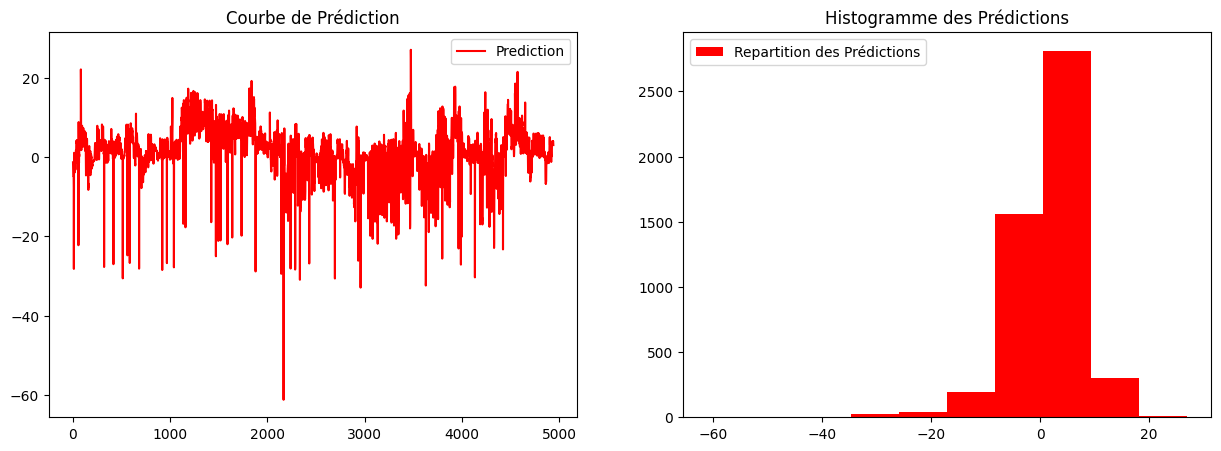

In [93]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(y_test_pred, label="Prediction", color='r')
axs[0].set_title("Courbe de Prédiction")
axs[0].legend()

axs[1].hist(y_test_pred, label="Repartition des Prédictions", color='r')
axs[1].set_title("Histogramme des Prédictions")
axs[1].legend()

plt.show()

# 0,5775900718416834

### optimisation avec Time Series CV

In [49]:
def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 100, 150)  # Increased range
    learning_rate = trial.suggest_float('learning_rate', 0.02, 0.027)  # Broader range
    subsample = trial.suggest_float('subsample', 0.95, 1.0)  # Lower bound for more randomness
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.95, 0.98)  # Lower bound for feature sampling
    reg_alpha = trial.suggest_float('reg_alpha', 0.0, 0.5)  # L1 regularization
    reg_lambda = trial.suggest_float('reg_lambda', 1e-3, 0.1)  # L2 regularization
    gamma = trial.suggest_float('gamma', 3.5, 5)  # Minimum loss reduction

    
    model = xgb.XGBRegressor(
        n_estimators=n_estimators,
        max_depth=4,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        min_child_weight=3,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        gamma=gamma,
        tree_method='hist',
        verbosity=0 
    )

    
    pipeline = make_pipeline(StandardScaler(), model)
    k = 10
    tscv = TimeSeriesSplit(n_splits=k)
    score = cross_val_score(pipeline, X_train, y_train, cv=tscv, scoring=weighted_accuracy_scorer).mean()

    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)


print("Best parameters:", study.best_params)
print("Best cross-validation score:", study.best_value)

[I 2024-11-10 22:06:53,853] A new study created in memory with name: no-name-1d4b69de-7c84-455f-9737-543bfbbabeec
[I 2024-11-10 22:06:54,479] Trial 0 finished with value: 0.5297440043193742 and parameters: {'n_estimators': 100, 'learning_rate': 0.024400368224169335, 'subsample': 0.9755373974703525, 'colsample_bytree': 0.9551205564130636, 'reg_alpha': 0.49138562082973725, 'reg_lambda': 0.029488321789120427, 'gamma': 4.791511644556061}. Best is trial 0 with value: 0.5297440043193742.
[I 2024-11-10 22:06:55,307] Trial 1 finished with value: 0.5083395001998989 and parameters: {'n_estimators': 144, 'learning_rate': 0.024954184978752313, 'subsample': 0.9833062248245021, 'colsample_bytree': 0.9729479628006019, 'reg_alpha': 0.16095597630232722, 'reg_lambda': 0.01619263799440203, 'gamma': 4.246642135288178}. Best is trial 0 with value: 0.5297440043193742.
[I 2024-11-10 22:06:56,116] Trial 2 finished with value: 0.4880372647959271 and parameters: {'n_estimators': 138, 'learning_rate': 0.02453985

Best parameters: {'n_estimators': 102, 'learning_rate': 0.022873821619390916, 'subsample': 0.9682714092424234, 'colsample_bytree': 0.9606580836039067, 'reg_alpha': 0.38898545662875417, 'reg_lambda': 0.0034498960718421737, 'gamma': 4.425211141788747}
Best cross-validation score: 0.5397149864607673


In [50]:
optuna.visualization.plot_param_importances(study)

In [51]:
optuna.visualization.plot_optimization_history(study)

In [52]:
optuna.visualization.plot_slice(study)

Best parameters: {'n_estimators': 102, 'learning_rate': 0.022873821619390916, 'subsample': 0.9682714092424234, 'colsample_bytree': 0.9606580836039067, 'reg_alpha': 0.38898545662875417, 'reg_lambda': 0.0034498960718421737, 'gamma': 4.425211141788747}
Best cross-validation score: 0.5397149864607673

In [53]:
warnings.filterwarnings("ignore", category=RuntimeWarning)

model = xgb.XGBRegressor(n_estimators = 102, max_depth = 4, learning_rate = 0.022873821619390916, subsample = 0.9682714092424234, colsample_bytree = 0.9606580836039067, 
                         min_child_weight = 3, reg_alpha = 0.38898545662875417, reg_lambda = 0.0034498960718421737, gamma = 4.425211141788747)
pipeline = make_pipeline(StandardScaler(), model)

cv_10_scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring=weighted_accuracy_scorer).round(4)
print(f"10 cv scores: {cv_10_scores}")

mean_cv_10_score = cv_10_scores.mean().round(4)
print("Mean Cross-Validation Weighted Accuracy:", mean_cv_10_score)



k = 10
tscv = TimeSeriesSplit(n_splits=k)

tscv_scores = cross_val_score(pipeline, X_train, y_train, cv=tscv, scoring=weighted_accuracy_scorer).round(4)
print(f"\ntscv scores: {tscv_scores}")

mean_tscv_score = tscv_scores.mean().round(4)
print("Mean Cross-Validation Weighted Accuracy:", mean_tscv_score)



pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_train)

test_weighted_accuracy = round(weighted_accuracy(y_train, predictions), 4)
print("\nOverfitted Weighted Accuracy:", test_weighted_accuracy)

y_test_pred = pipeline.predict(X_test)

10 cv scores: [0.6233 0.3851 0.3721 0.458  0.6459 0.5621 0.6107 0.5848 0.6311 0.5848]
Mean Cross-Validation Weighted Accuracy: 0.5458

tscv scores: [0.5884 0.5635 0.3368 0.6217 0.595  0.4915 0.584  0.4591 0.4757 0.6813]
Mean Cross-Validation Weighted Accuracy: 0.5397

Overfitted Weighted Accuracy: 0.7446


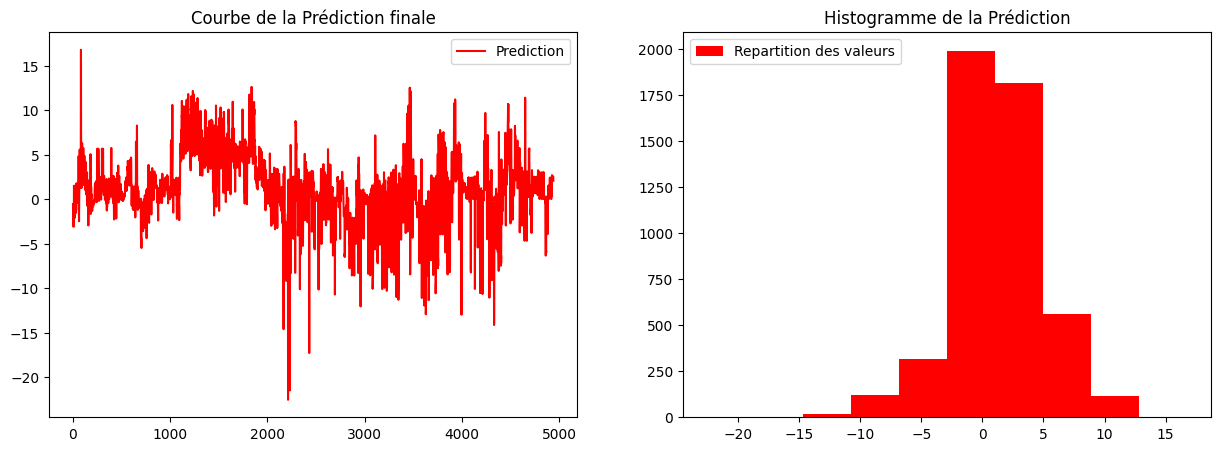

In [65]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(y_test_pred, label="Prediction", color='r')
axs[0].set_title("Courbe de la Prédiction finale")
axs[0].legend()

axs[1].hist(y_test_pred, label="Repartition des valeurs", color='r')
axs[1].set_title("Histogramme de la Prédiction")
axs[1].legend()

plt.show()

# 0,5872786313078668

## 2) LGBM Regressor

In [121]:
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

model = lgb.LGBMRegressor(verbosity=-1)
pipeline = make_pipeline(StandardScaler(), model)

cv_10_scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring=weighted_accuracy_scorer).round(4)
print(f"10 cv scores: {cv_10_scores}")

mean_cv_10_score = cv_10_scores.mean().round(4)
print("Mean Cross-Validation Weighted Accuracy:", mean_cv_10_score)



k = 10
tscv = TimeSeriesSplit(n_splits=k)

tscv_scores = cross_val_score(pipeline, X_train, y_train, cv=tscv, scoring=weighted_accuracy_scorer).round(4)
print(f"\ntscv scores: {tscv_scores}")

mean_tscv_score = tscv_scores.mean().round(4)
print("Mean Cross-Validation Weighted Accuracy:", mean_tscv_score)



pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_train)

test_weighted_accuracy = round(weighted_accuracy(y_train, predictions), 4)
print("\nOverfitted Weighted Accuracy:", test_weighted_accuracy)

y_test_pred = pipeline.predict(X_test)

10 cv scores: [0.5003 0.4328 0.4073 0.4475 0.5488 0.6067 0.6026 0.4289 0.5014 0.5766]
Mean Cross-Validation Weighted Accuracy: 0.5053

tscv scores: [0.5873 0.5495 0.5086 0.5678 0.6362 0.48   0.5162 0.5334 0.4273 0.53  ]
Mean Cross-Validation Weighted Accuracy: 0.5336

Overfitted Weighted Accuracy: 0.9035


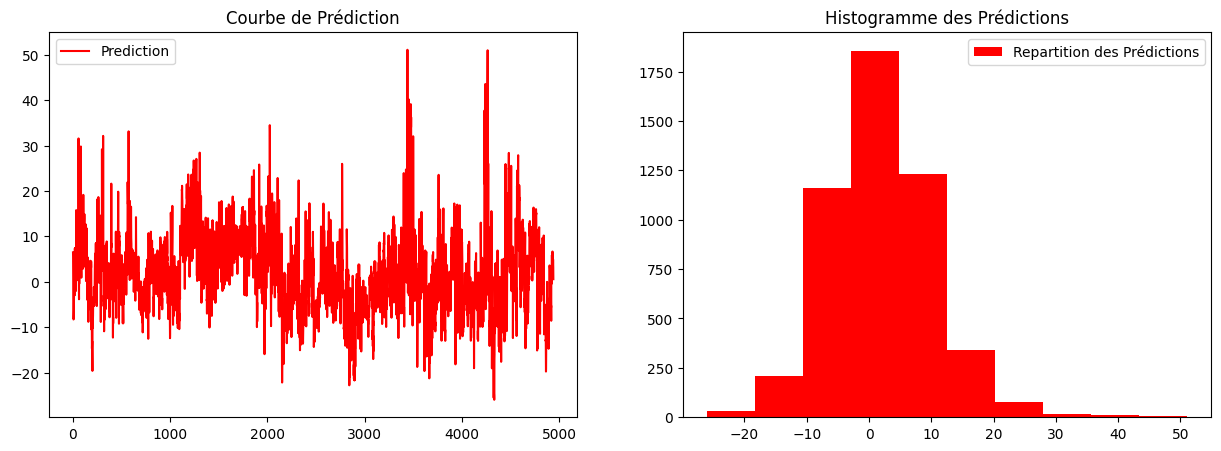

In [124]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(y_test_pred, label="Prediction", color='r')
axs[0].set_title("Courbe de Prédiction")
axs[0].legend()

axs[1].hist(y_test_pred, label="Repartition des Prédictions", color='r')
axs[1].set_title("Histogramme des Prédictions")
axs[1].legend()

plt.show()

# 0,5259793654284036

## 3) CatBoost Regressor

In [125]:
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

model = CatBoostRegressor(verbose=0)
pipeline = make_pipeline(StandardScaler(), model)

cv_10_scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring=weighted_accuracy_scorer).round(4)
print(f"10 cv scores: {cv_10_scores}")

mean_cv_10_score = cv_10_scores.mean().round(4)
print("Mean Cross-Validation Weighted Accuracy:", mean_cv_10_score)



k = 10
tscv = TimeSeriesSplit(n_splits=k)

tscv_scores = cross_val_score(pipeline, X_train, y_train, cv=tscv, scoring=weighted_accuracy_scorer).round(4)
print(f"\ntscv scores: {tscv_scores}")

mean_tscv_score = tscv_scores.mean().round(4)
print("Mean Cross-Validation Weighted Accuracy:", mean_tscv_score)



pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_train)

test_weighted_accuracy = round(weighted_accuracy(y_train, predictions), 4)
print("\nOverfitted Weighted Accuracy:", test_weighted_accuracy)

y_test_pred = pipeline.predict(X_test)

10 cv scores: [0.5306 0.4234 0.3568 0.5601 0.5052 0.5686 0.4628 0.439  0.5068 0.5023]
Mean Cross-Validation Weighted Accuracy: 0.4856

tscv scores: [0.5863 0.6313 0.4618 0.6022 0.6109 0.5564 0.5248 0.4734 0.3518 0.5488]
Mean Cross-Validation Weighted Accuracy: 0.5348

Overfitted Weighted Accuracy: 0.9218


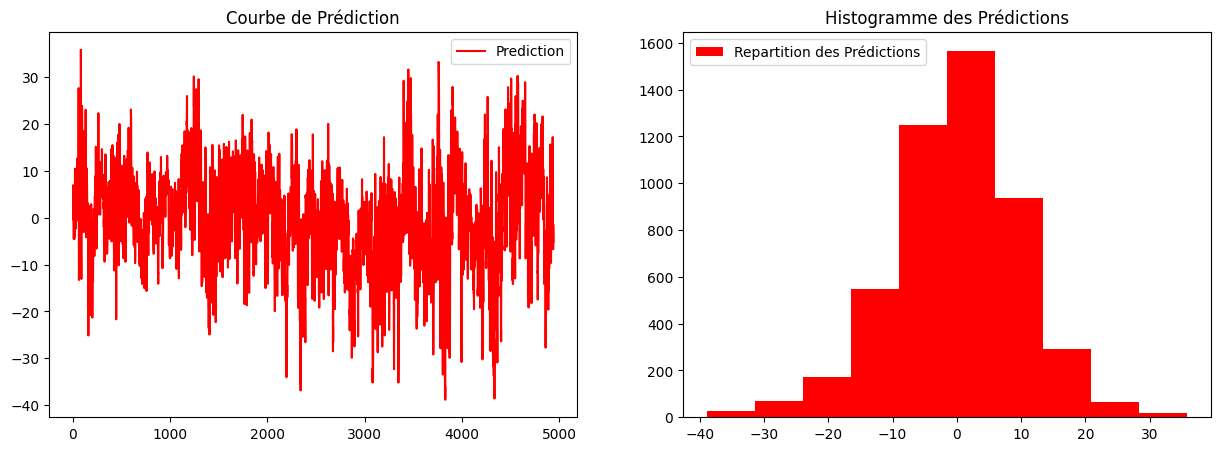

In [128]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(y_test_pred, label="Prediction", color='r')
axs[0].set_title("Courbe de Prédiction")
axs[0].legend()

axs[1].hist(y_test_pred, label="Repartition des Prédictions", color='r')
axs[1].set_title("Histogramme des Prédictions")
axs[1].legend()

plt.show()

# 0,5291414505511338

# 5. Traitement des valeurs manquantes

In [73]:
X_train.isna().sum()

load_forecast                    1287
coal_power_available                1
gas_power_available                 1
nucelear_power_available            1
wind_power_forecasts_average       24
solar_power_forecasts_average      24
wind_power_forecasts_std           24
solar_power_forecasts_std          24
predicted_spot_price             8759
hour                                0
day                                 0
month                               0
year                                0
dtype: int64

In [74]:
X_test.isna().sum()

load_forecast                       0
coal_power_available                0
gas_power_available                 0
nucelear_power_available            0
wind_power_forecasts_average        0
solar_power_forecasts_average      24
wind_power_forecasts_std            0
solar_power_forecasts_std          24
predicted_spot_price             1536
hour                                0
day                                 0
month                               0
year                                0
dtype: int64

In [75]:
missing_indices = {}
for column in X_train.columns:
    missing_indices[column] = X_train[X_train[column].isna()].index.tolist()

for column, indices in missing_indices.items():
    print(f"Colonne '{column}' : {len(indices)} valeurs manquantes aux index : {indices}")

Colonne 'load_forecast' : 1287 valeurs manquantes aux index : [4174, 4175, 4176, 4177, 4178, 4179, 4180, 4181, 4182, 4183, 4184, 4185, 4186, 4187, 4188, 4189, 4190, 4191, 4192, 4193, 4194, 4195, 4196, 4197, 4198, 4199, 4200, 4201, 4202, 4203, 4204, 4205, 4206, 4207, 4208, 4209, 4210, 4211, 4212, 4213, 4214, 4215, 4216, 4217, 4218, 4219, 4220, 4221, 4222, 4223, 4224, 4225, 4226, 4227, 4228, 4229, 4230, 4231, 4232, 4233, 4234, 4235, 4236, 4237, 4238, 4239, 4240, 4241, 4242, 4243, 4244, 4245, 4246, 4247, 4248, 4249, 4250, 4251, 4252, 4253, 4254, 4255, 4256, 4257, 4258, 4259, 4260, 4261, 4262, 4263, 4264, 4265, 4266, 4267, 4268, 4269, 4270, 4271, 4272, 4273, 4274, 4275, 4276, 4277, 4278, 4279, 4280, 4281, 4282, 4283, 4284, 4285, 4286, 4287, 4288, 4289, 4290, 4291, 4292, 4293, 4294, 4295, 4296, 4297, 4298, 4299, 4300, 4301, 4302, 4303, 4304, 4305, 4306, 4307, 4308, 4309, 4310, 4311, 4312, 4313, 4314, 4315, 4316, 4317, 4318, 4319, 4320, 4321, 4322, 4323, 4324, 4325, 4326, 4327, 4328, 4329, 4

In [76]:
# drop de cette ligne
X_train = X_train.drop(7008)
y_train = y_train.drop(7008)

# remplacement de solar power
X_train2 = X_train.copy()
X_train.loc[9713:9713+11, ["solar_power_forecasts_std"]] = 0
X_train.loc[9737:9737+11, ["solar_power_forecasts_std"]] = 0
X_train.loc[9725:9725+11, ["solar_power_forecasts_std"]] = (X_train.loc[9701:9701+11, ["solar_power_forecasts_std"]].copy().values + X_train.loc[9749:9749+11, ["solar_power_forecasts_std"]].copy().values) / 2

X_train.loc[9713:9713+11, ["solar_power_forecasts_average"]] = 0
X_train.loc[9737:9737+11, ["solar_power_forecasts_average"]] = 0
X_train.loc[9725:9725+11, ["solar_power_forecasts_average"]] = (X_train.loc[9701:9701+11, ["solar_power_forecasts_average"]].copy().values + X_train.loc[9749:9749+11, ["solar_power_forecasts_average"]].copy().values) / 2

#remplacement de wind power
X_train['wind_power_forecasts_average'] = X_train['wind_power_forecasts_average'].interpolate(method='spline', order=3)
X_train['wind_power_forecasts_std'] = X_train['wind_power_forecasts_std'].interpolate(method='pchip')

#remplacement de solar power dans X test
X_test.loc[622:623, "solar_power_forecasts_average"] = 0
X_test.loc[600:605, "solar_power_forecasts_average"] = 0
X_test.loc[606:621, "solar_power_forecasts_average"] = X_test.loc[582:597, "solar_power_forecasts_average"].values

X_test.loc[622:623, "solar_power_forecasts_std"] = 0
X_test.loc[600:605, "solar_power_forecasts_std"] = 0
X_test.loc[606:621, "solar_power_forecasts_std"] = X_test.loc[582:597, "solar_power_forecasts_std"].values

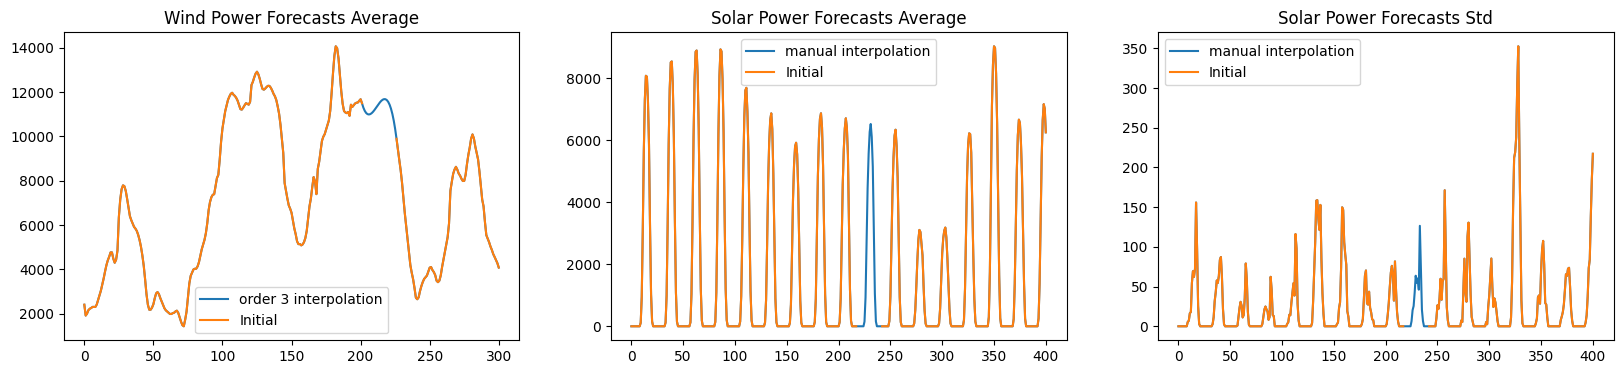

In [77]:
fig, axs = plt.subplots(1, 3, figsize=(20, 4))

# Tracé pour "wind_power_forecasts_average"
axs[0].plot(X_train.loc[8100:8400, ["wind_power_forecasts_average"]].values, label="order 3 interpolation")
axs[0].plot(X_train2.loc[8100:8400, ["wind_power_forecasts_average"]].values, label="Initial")
axs[0].set_title("Wind Power Forecasts Average")
axs[0].legend()

# Tracé pour "solar_power_forecasts_average"
axs[1].plot(X_train.loc[9500:9900, ["solar_power_forecasts_average"]].values, label="manual interpolation")
axs[1].plot(X_train2.loc[9500:9900, ["solar_power_forecasts_average"]].values, label="Initial")
axs[1].set_title("Solar Power Forecasts Average")
axs[1].legend()

# Tracé pour "solar_power_forecasts_std"
axs[2].plot(X_train.loc[9500:9900, ["solar_power_forecasts_std"]].values, label="manual interpolation")
axs[2].plot(X_train2.loc[9500:9900, ["solar_power_forecasts_std"]].values, label="Initial")
axs[2].set_title("Solar Power Forecasts Std")
axs[2].legend()

plt.show()

In [78]:
nan_indices = X_train[X_train['load_forecast'].isna()].index

X_train.drop(nan_indices, inplace=True)
y_train.drop(nan_indices, inplace=True)

In [79]:
X_train_fill0 = X_train.copy()
X_train_fill0['is_prediction_available'] = X_train_fill0['predicted_spot_price'].notna().astype(int)
X_train_fill0['predicted_spot_price'] = X_train_fill0['predicted_spot_price'].fillna(0)

X_test_fill0 = X_test.copy()
X_test_fill0['is_prediction_available'] = X_test_fill0['predicted_spot_price'].notna().astype(int)
X_test_fill0['predicted_spot_price'] = X_test_fill0['predicted_spot_price'].fillna(0)

X_train_drop = X_train_fill0.loc[8500:].copy()
y_train_drop = y_train.loc[X_train_drop.index].copy()

# 1) test de différents modèles pour X_train_fill0

### XGboost Regressor

In [85]:
warnings.filterwarnings("ignore", category=RuntimeWarning)

model = xgb.XGBRegressor()
pipeline = make_pipeline(StandardScaler(), model)

cv_10_scores = cross_val_score(pipeline, X_train_fill0, y_train, cv=10, scoring=weighted_accuracy_scorer).round(4)
print(f"10 cv scores: {cv_10_scores}")

mean_cv_10_score = cv_10_scores.mean().round(4)
print("Mean Cross-Validation Weighted Accuracy:", mean_cv_10_score)



k = 10
tscv = TimeSeriesSplit(n_splits=k)

tscv_scores = cross_val_score(pipeline, X_train_fill0, y_train, cv=tscv, scoring=weighted_accuracy_scorer).round(4)
print(f"\ntscv scores: {tscv_scores}")

mean_tscv_score = tscv_scores.mean().round(4)
print("Mean Cross-Validation Weighted Accuracy:", mean_tscv_score)



pipeline.fit(X_train_fill0, y_train)
predictions = pipeline.predict(X_train_fill0)

test_weighted_accuracy = round(weighted_accuracy(y_train, predictions), 4)
print("\nOverfitted Weighted Accuracy:", test_weighted_accuracy)

y_test_pred = pipeline.predict(X_test_fill0)

10 cv scores: [0.5206 0.4782 0.6178 0.4898 0.4695 0.5361 0.5007 0.4776 0.445  0.5483]
Mean Cross-Validation Weighted Accuracy: 0.5084

tscv scores: [0.3489 0.6621 0.4747 0.5374 0.4392 0.5259 0.4246 0.514  0.4577 0.5291]
Mean Cross-Validation Weighted Accuracy: 0.4914

Overfitted Weighted Accuracy: 0.9628


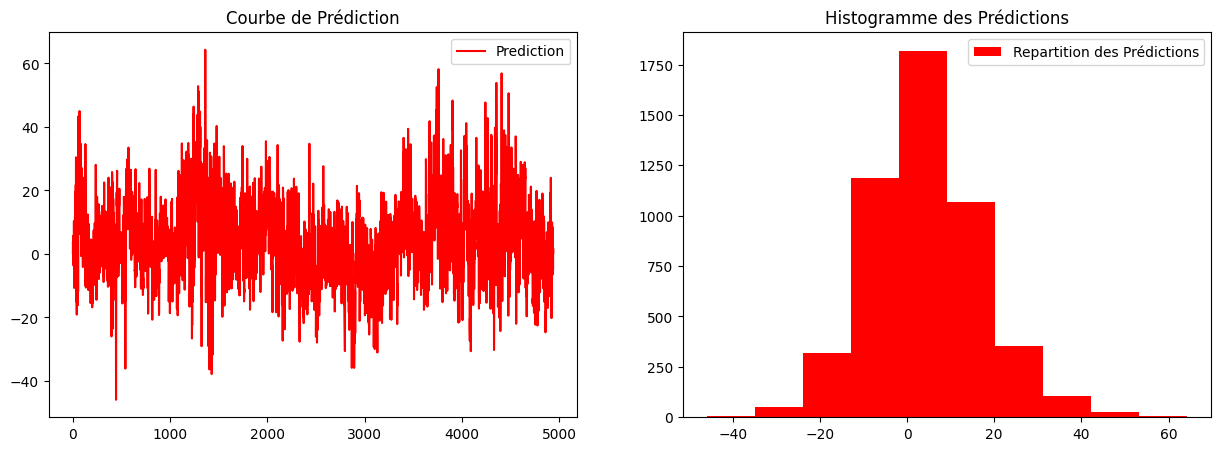

In [88]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(y_test_pred, label="Prediction", color='r')
axs[0].set_title("Courbe de Prédiction")
axs[0].legend()

axs[1].hist(y_test_pred, label="Repartition des Prédictions", color='r')
axs[1].set_title("Histogramme des Prédictions")
axs[1].legend()

plt.show()

# 0,5284549965268172

## LGBM Regressor

In [95]:
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

model = lgb.LGBMRegressor(verbosity=-1)
pipeline = make_pipeline(StandardScaler(), model)

cv_10_scores = cross_val_score(pipeline, X_train_fill0, y_train, cv=10, scoring=weighted_accuracy_scorer).round(4)
print(f"10 cv scores: {cv_10_scores}")

mean_cv_10_score = cv_10_scores.mean().round(4)
print("Mean Cross-Validation Weighted Accuracy:", mean_cv_10_score)



k = 10
tscv = TimeSeriesSplit(n_splits=k)

tscv_scores = cross_val_score(pipeline, X_train_fill0, y_train, cv=tscv, scoring=weighted_accuracy_scorer).round(4)
print(f"\ntscv scores: {tscv_scores}")

mean_tscv_score = tscv_scores.mean().round(4)
print("Mean Cross-Validation Weighted Accuracy:", mean_tscv_score)



pipeline.fit(X_train_fill0, y_train)
predictions = pipeline.predict(X_train_fill0)

test_weighted_accuracy = round(weighted_accuracy(y_train, predictions), 4)
print("\nOverfitted Weighted Accuracy:", test_weighted_accuracy)

y_test_pred = pipeline.predict(X_test_fill0)

10 cv scores: [0.6076 0.448  0.4472 0.5135 0.4791 0.6142 0.4893 0.468  0.4716 0.5114]
Mean Cross-Validation Weighted Accuracy: 0.505

tscv scores: [0.5659 0.6324 0.5075 0.5604 0.4461 0.5666 0.3797 0.5107 0.3856 0.6161]
Mean Cross-Validation Weighted Accuracy: 0.5171

Overfitted Weighted Accuracy: 0.9068


## CatBoostRegressor

In [96]:
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

model = CatBoostRegressor(verbose=0)
pipeline = make_pipeline(StandardScaler(), model)

cv_10_scores = cross_val_score(pipeline, X_train_fill0, y_train, cv=10, scoring=weighted_accuracy_scorer).round(4)
print(f"10 cv scores: {cv_10_scores}")

mean_cv_10_score = cv_10_scores.mean().round(4)
print("Mean Cross-Validation Weighted Accuracy:", mean_cv_10_score)



k = 10
tscv = TimeSeriesSplit(n_splits=k)

tscv_scores = cross_val_score(pipeline, X_train_fill0, y_train, cv=tscv, scoring=weighted_accuracy_scorer).round(4)
print(f"\ntscv scores: {tscv_scores}")

mean_tscv_score = tscv_scores.mean().round(4)
print("Mean Cross-Validation Weighted Accuracy:", mean_tscv_score)



pipeline.fit(X_train_fill0, y_train)
predictions = pipeline.predict(X_train_fill0)

test_weighted_accuracy = round(weighted_accuracy(y_train, predictions), 4)
print("\nOverfitted Weighted Accuracy:", test_weighted_accuracy)

y_test_pred = pipeline.predict(X_test_fill0)

10 cv scores: [0.6513 0.5022 0.6793 0.5639 0.4901 0.6143 0.5332 0.4193 0.5245 0.4587]
Mean Cross-Validation Weighted Accuracy: 0.5437

tscv scores: [0.5565 0.6318 0.4739 0.4955 0.4298 0.6132 0.3609 0.5531 0.3979 0.4172]
Mean Cross-Validation Weighted Accuracy: 0.493

Overfitted Weighted Accuracy: 0.9282


## Random Forest

In [97]:
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

model = RandomForestRegressor(random_state=0)
pipeline = make_pipeline(StandardScaler(), model)

cv_10_scores = cross_val_score(pipeline, X_train_fill0, y_train, cv=10, scoring=weighted_accuracy_scorer).round(4)
print(f"10 cv scores: {cv_10_scores}")

mean_cv_10_score = cv_10_scores.mean().round(4)
print("Mean Cross-Validation Weighted Accuracy:", mean_cv_10_score)



k = 10
tscv = TimeSeriesSplit(n_splits=k)

tscv_scores = cross_val_score(pipeline, X_train_fill0, y_train, cv=tscv, scoring=weighted_accuracy_scorer).round(4)
print(f"\ntscv scores: {tscv_scores}")

mean_tscv_score = tscv_scores.mean().round(4)
print("Mean Cross-Validation Weighted Accuracy:", mean_tscv_score)



pipeline.fit(X_train_fill0, y_train)
predictions = pipeline.predict(X_train_fill0)

test_weighted_accuracy = round(weighted_accuracy(y_train, predictions), 4)
print("\nOverfitted Weighted Accuracy:", test_weighted_accuracy)

y_test_pred = pipeline.predict(X_test_fill0)

10 cv scores: [0.6368 0.4949 0.3876 0.5892 0.494  0.563  0.5416 0.4332 0.6027 0.5032]
Mean Cross-Validation Weighted Accuracy: 0.5246

tscv scores: [0.5215 0.6025 0.4635 0.5197 0.441  0.6215 0.4005 0.5505 0.4117 0.5095]
Mean Cross-Validation Weighted Accuracy: 0.5042

Overfitted Weighted Accuracy: 0.9922


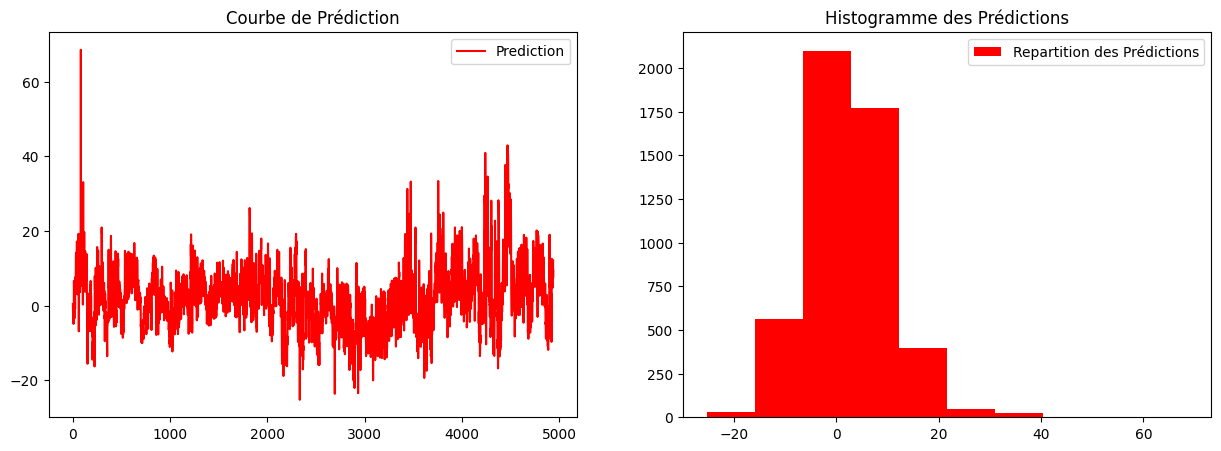

In [100]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(y_test_pred, label="Prediction", color='r')
axs[0].set_title("Courbe de Prédiction")
axs[0].legend()

axs[1].hist(y_test_pred, label="Repartition des Prédictions", color='r')
axs[1].set_title("Histogramme des Prédictions")
axs[1].legend()

plt.show()

# 0,551637151348145

## Gradient Boosting Regressor

In [101]:
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

model = GradientBoostingRegressor()
pipeline = make_pipeline(StandardScaler(), model)

cv_10_scores = cross_val_score(pipeline, X_train_fill0, y_train, cv=10, scoring=weighted_accuracy_scorer).round(4)
print(f"10 cv scores: {cv_10_scores}")

mean_cv_10_score = cv_10_scores.mean().round(4)
print("Mean Cross-Validation Weighted Accuracy:", mean_cv_10_score)



k = 10
tscv = TimeSeriesSplit(n_splits=k)

tscv_scores = cross_val_score(pipeline, X_train_fill0, y_train, cv=tscv, scoring=weighted_accuracy_scorer).round(4)
print(f"\ntscv scores: {tscv_scores}")

mean_tscv_score = tscv_scores.mean().round(4)
print("Mean Cross-Validation Weighted Accuracy:", mean_tscv_score)



pipeline.fit(X_train_fill0, y_train)
predictions = pipeline.predict(X_train_fill0)

test_weighted_accuracy = round(weighted_accuracy(y_train, predictions), 4)
print("\nOverfitted Weighted Accuracy:", test_weighted_accuracy)

y_test_pred = pipeline.predict(X_test_fill0)

10 cv scores: [0.5434 0.4834 0.4419 0.4884 0.4869 0.5431 0.5502 0.3796 0.5115 0.5273]
Mean Cross-Validation Weighted Accuracy: 0.4956

tscv scores: [0.4247 0.5958 0.4805 0.4945 0.4537 0.5994 0.3855 0.5417 0.435  0.5019]
Mean Cross-Validation Weighted Accuracy: 0.4913

Overfitted Weighted Accuracy: 0.7791


## AdaBoost Regressor

In [102]:
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

model = AdaBoostRegressor()
pipeline = make_pipeline(StandardScaler(), model)

cv_10_scores = cross_val_score(pipeline, X_train_fill0, y_train, cv=10, scoring=weighted_accuracy_scorer).round(4)
print(f"10 cv scores: {cv_10_scores}")

mean_cv_10_score = cv_10_scores.mean().round(4)
print("Mean Cross-Validation Weighted Accuracy:", mean_cv_10_score)



k = 10
tscv = TimeSeriesSplit(n_splits=k)

tscv_scores = cross_val_score(pipeline, X_train_fill0, y_train, cv=tscv, scoring=weighted_accuracy_scorer).round(4)
print(f"\ntscv scores: {tscv_scores}")

mean_tscv_score = tscv_scores.mean().round(4)
print("Mean Cross-Validation Weighted Accuracy:", mean_tscv_score)



pipeline.fit(X_train_fill0, y_train)
predictions = pipeline.predict(X_train_fill0)

test_weighted_accuracy = round(weighted_accuracy(y_train, predictions), 4)
print("\nOverfitted Weighted Accuracy:", test_weighted_accuracy)

y_test_pred = pipeline.predict(X_test_fill0)

10 cv scores: [0.5482 0.4224 0.3967 0.4851 0.4678 0.5459 0.5825 0.4994 0.5923 0.5748]
Mean Cross-Validation Weighted Accuracy: 0.5115

tscv scores: [0.5746 0.3584 0.4161 0.275  0.4253 0.5758 0.3823 0.5291 0.6424 0.4936]
Mean Cross-Validation Weighted Accuracy: 0.4673

Overfitted Weighted Accuracy: 0.6201


## Ridge

In [103]:
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

model = Ridge()
pipeline = make_pipeline(StandardScaler(), model)

cv_10_scores = cross_val_score(pipeline, X_train_fill0, y_train, cv=10, scoring=weighted_accuracy_scorer).round(4)
print(f"10 cv scores: {cv_10_scores}")

mean_cv_10_score = cv_10_scores.mean().round(4)
print("Mean Cross-Validation Weighted Accuracy:", mean_cv_10_score)



k = 10
tscv = TimeSeriesSplit(n_splits=k)

tscv_scores = cross_val_score(pipeline, X_train_fill0, y_train, cv=tscv, scoring=weighted_accuracy_scorer).round(4)
print(f"\ntscv scores: {tscv_scores}")

mean_tscv_score = tscv_scores.mean().round(4)
print("Mean Cross-Validation Weighted Accuracy:", mean_tscv_score)



pipeline.fit(X_train_fill0, y_train)
predictions = pipeline.predict(X_train_fill0)

test_weighted_accuracy = round(weighted_accuracy(y_train, predictions), 4)
print("\nOverfitted Weighted Accuracy:", test_weighted_accuracy)

y_test_pred = pipeline.predict(X_test_fill0)

10 cv scores: [0.4555 0.5676 0.4725 0.4769 0.5529 0.543  0.4759 0.5507 0.6253 0.6417]
Mean Cross-Validation Weighted Accuracy: 0.5362

tscv scores: [0.6873 0.6679 0.469  0.5164 0.4172 0.5113 0.3716 0.5213 0.5009 0.641 ]
Mean Cross-Validation Weighted Accuracy: 0.5304

Overfitted Weighted Accuracy: 0.5923


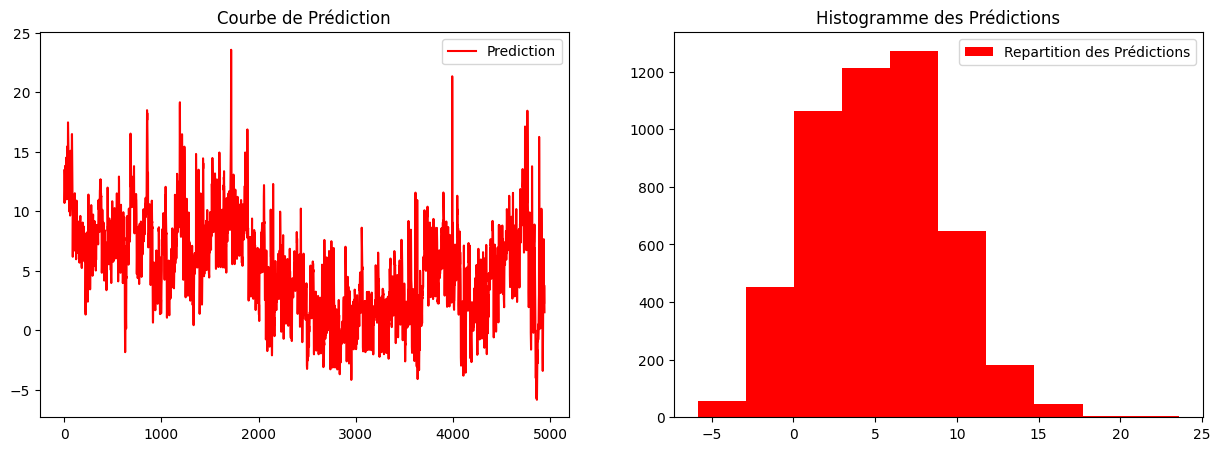

In [106]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(y_test_pred, label="Prediction", color='r')
axs[0].set_title("Courbe de Prédiction")
axs[0].legend()

axs[1].hist(y_test_pred, label="Repartition des Prédictions", color='r')
axs[1].set_title("Histogramme des Prédictions")
axs[1].legend()

plt.show()

# 0,5444178009867662

## Lasso

In [107]:
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

model = Lasso()
pipeline = make_pipeline(StandardScaler(), model)

cv_10_scores = cross_val_score(pipeline, X_train_fill0, y_train, cv=10, scoring=weighted_accuracy_scorer).round(4)
print(f"10 cv scores: {cv_10_scores}")

mean_cv_10_score = cv_10_scores.mean().round(4)
print("Mean Cross-Validation Weighted Accuracy:", mean_cv_10_score)



k = 10
tscv = TimeSeriesSplit(n_splits=k)

tscv_scores = cross_val_score(pipeline, X_train_fill0, y_train, cv=tscv, scoring=weighted_accuracy_scorer).round(4)
print(f"\ntscv scores: {tscv_scores}")

mean_tscv_score = tscv_scores.mean().round(4)
print("Mean Cross-Validation Weighted Accuracy:", mean_tscv_score)



pipeline.fit(X_train_fill0, y_train)
predictions = pipeline.predict(X_train_fill0)

test_weighted_accuracy = round(weighted_accuracy(y_train, predictions), 4)
print("\nOverfitted Weighted Accuracy:", test_weighted_accuracy)

y_test_pred = pipeline.predict(X_test_fill0)

10 cv scores: [0.5869 0.3719 0.3671 0.3998 0.4719 0.5214 0.4335 0.4686 0.6387 0.4636]
Mean Cross-Validation Weighted Accuracy: 0.4723

tscv scores: [0.6873 0.6436 0.4778 0.5328 0.4409 0.5109 0.3576 0.5308 0.3749 0.4325]
Mean Cross-Validation Weighted Accuracy: 0.4989

Overfitted Weighted Accuracy: 0.5367


## ElasticNet

In [108]:
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

model = ElasticNet()
pipeline = make_pipeline(StandardScaler(), model)

cv_10_scores = cross_val_score(pipeline, X_train_fill0, y_train, cv=10, scoring=weighted_accuracy_scorer).round(4)
print(f"10 cv scores: {cv_10_scores}")

mean_cv_10_score = cv_10_scores.mean().round(4)
print("Mean Cross-Validation Weighted Accuracy:", mean_cv_10_score)



k = 10
tscv = TimeSeriesSplit(n_splits=k)

tscv_scores = cross_val_score(pipeline, X_train_fill0, y_train, cv=tscv, scoring=weighted_accuracy_scorer).round(4)
print(f"\ntscv scores: {tscv_scores}")

mean_tscv_score = tscv_scores.mean().round(4)
print("Mean Cross-Validation Weighted Accuracy:", mean_tscv_score)



pipeline.fit(X_train_fill0, y_train)
predictions = pipeline.predict(X_train_fill0)

test_weighted_accuracy = round(weighted_accuracy(y_train, predictions), 4)
print("\nOverfitted Weighted Accuracy:", test_weighted_accuracy)

y_test_pred = pipeline.predict(X_test_fill0)

10 cv scores: [0.5686 0.378  0.3777 0.4377 0.4719 0.5105 0.43   0.577  0.6387 0.5468]
Mean Cross-Validation Weighted Accuracy: 0.4937

tscv scores: [0.6828 0.648  0.4757 0.5448 0.4564 0.513  0.3576 0.6034 0.4139 0.5152]
Mean Cross-Validation Weighted Accuracy: 0.5211

Overfitted Weighted Accuracy: 0.5619


## BayesianRidge

In [110]:
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

model = BayesianRidge()
pipeline = make_pipeline(StandardScaler(), model)

cv_10_scores = cross_val_score(pipeline, X_train_fill0, y_train, cv=10, scoring=weighted_accuracy_scorer).round(4)
print(f"10 cv scores: {cv_10_scores}")

mean_cv_10_score = cv_10_scores.mean().round(4)
print("Mean Cross-Validation Weighted Accuracy:", mean_cv_10_score)



k = 10
tscv = TimeSeriesSplit(n_splits=k)

tscv_scores = cross_val_score(pipeline, X_train_fill0, y_train, cv=tscv, scoring=weighted_accuracy_scorer).round(4)
print(f"\ntscv scores: {tscv_scores}")

mean_tscv_score = tscv_scores.mean().round(4)
print("Mean Cross-Validation Weighted Accuracy:", mean_tscv_score)



pipeline.fit(X_train_fill0, y_train)
predictions = pipeline.predict(X_train_fill0)

test_weighted_accuracy = round(weighted_accuracy(y_train, predictions), 4)
print("\nOverfitted Weighted Accuracy:", test_weighted_accuracy)

y_test_pred = pipeline.predict(X_test_fill0)

10 cv scores: [0.4931 0.4914 0.4733 0.477  0.5539 0.5303 0.4769 0.5442 0.6229 0.6116]
Mean Cross-Validation Weighted Accuracy: 0.5275

tscv scores: [0.6853 0.6699 0.4652 0.5782 0.4348 0.5113 0.361  0.4983 0.5059 0.6025]
Mean Cross-Validation Weighted Accuracy: 0.5312

Overfitted Weighted Accuracy: 0.5916


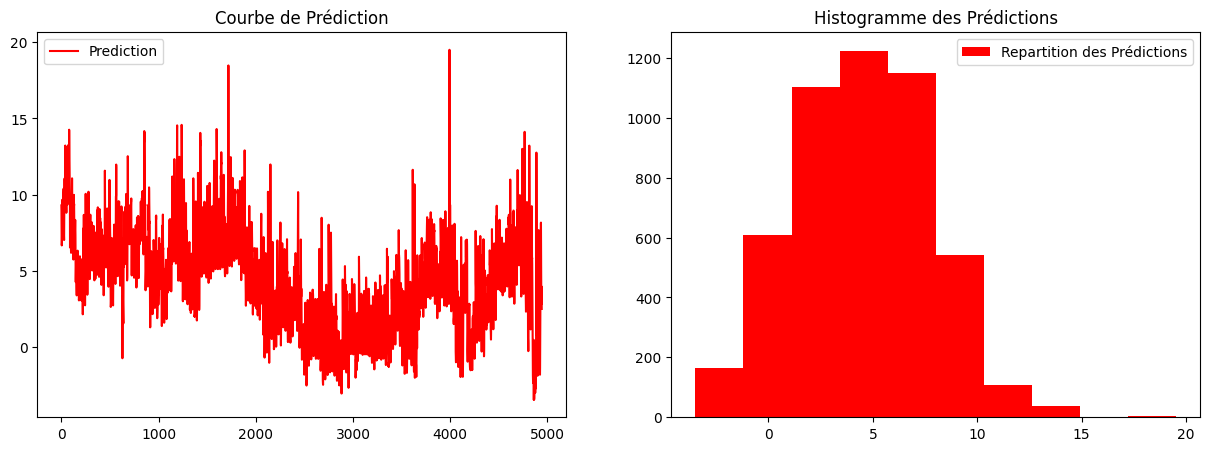

In [113]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(y_test_pred, label="Prediction", color='r')
axs[0].set_title("Courbe de Prédiction")
axs[0].legend()

axs[1].hist(y_test_pred, label="Repartition des Prédictions", color='r')
axs[1].set_title("Histogramme des Prédictions")
axs[1].legend()

plt.show()

## SVR

In [115]:
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

model = SVR()
pipeline = make_pipeline(StandardScaler(), model)

cv_10_scores = cross_val_score(pipeline, X_train_fill0, y_train, cv=10, scoring=weighted_accuracy_scorer).round(4)
print(f"10 cv scores: {cv_10_scores}")

mean_cv_10_score = cv_10_scores.mean().round(4)
print("Mean Cross-Validation Weighted Accuracy:", mean_cv_10_score)



k = 10
tscv = TimeSeriesSplit(n_splits=k)

tscv_scores = cross_val_score(pipeline, X_train_fill0, y_train, cv=tscv, scoring=weighted_accuracy_scorer).round(4)
print(f"\ntscv scores: {tscv_scores}")

mean_tscv_score = tscv_scores.mean().round(4)
print("Mean Cross-Validation Weighted Accuracy:", mean_tscv_score)



pipeline.fit(X_train_fill0, y_train)
predictions = pipeline.predict(X_train_fill0)

test_weighted_accuracy = round(weighted_accuracy(y_train, predictions), 4)
print("\nOverfitted Weighted Accuracy:", test_weighted_accuracy)

y_test_pred = pipeline.predict(X_test_fill0)

10 cv scores: [0.4449 0.5962 0.4298 0.461  0.5445 0.4619 0.5524 0.5621 0.4935 0.5245]
Mean Cross-Validation Weighted Accuracy: 0.5071

tscv scores: [0.6873 0.6586 0.4834 0.4509 0.4112 0.5276 0.3786 0.4344 0.6393 0.4069]
Mean Cross-Validation Weighted Accuracy: 0.5078

Overfitted Weighted Accuracy: 0.6774


## KNeighborsRegressor

In [116]:
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

model = KNeighborsRegressor()
pipeline = make_pipeline(StandardScaler(), model)

cv_10_scores = cross_val_score(pipeline, X_train_fill0, y_train, cv=10, scoring=weighted_accuracy_scorer).round(4)
print(f"10 cv scores: {cv_10_scores}")

mean_cv_10_score = cv_10_scores.mean().round(4)
print("Mean Cross-Validation Weighted Accuracy:", mean_cv_10_score)



k = 10
tscv = TimeSeriesSplit(n_splits=k)

tscv_scores = cross_val_score(pipeline, X_train_fill0, y_train, cv=tscv, scoring=weighted_accuracy_scorer).round(4)
print(f"\ntscv scores: {tscv_scores}")

mean_tscv_score = tscv_scores.mean().round(4)
print("Mean Cross-Validation Weighted Accuracy:", mean_tscv_score)



pipeline.fit(X_train_fill0, y_train)
predictions = pipeline.predict(X_train_fill0)

test_weighted_accuracy = round(weighted_accuracy(y_train, predictions), 4)
print("\nOverfitted Weighted Accuracy:", test_weighted_accuracy)

y_test_pred = pipeline.predict(X_test_fill0)

10 cv scores: [0.4357 0.5964 0.6192 0.492  0.4715 0.5524 0.5342 0.5008 0.5498 0.5588]
Mean Cross-Validation Weighted Accuracy: 0.5311

tscv scores: [0.5834 0.6663 0.5031 0.4379 0.4684 0.4948 0.4496 0.5835 0.5382 0.4894]
Mean Cross-Validation Weighted Accuracy: 0.5215

Overfitted Weighted Accuracy: 0.9205


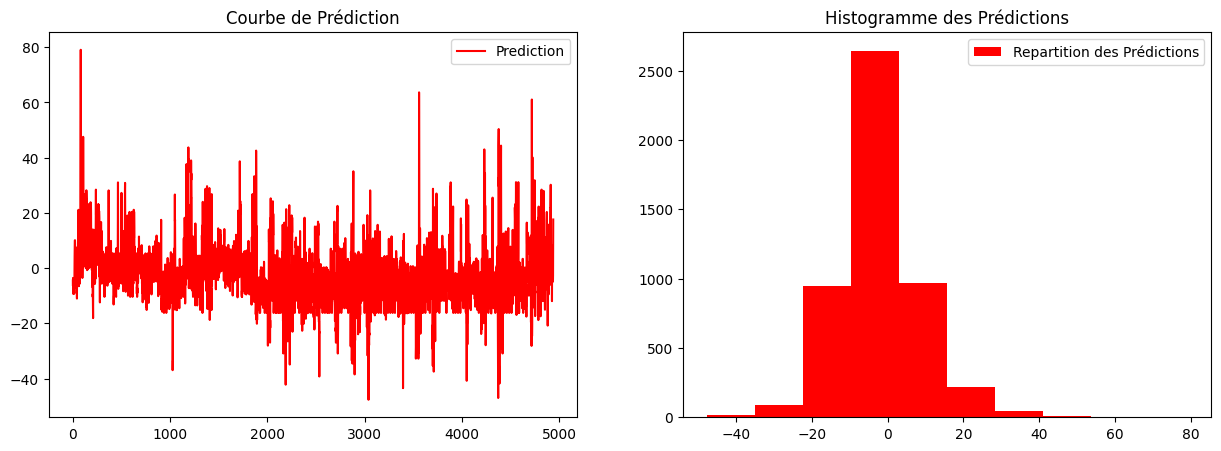

In [121]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(y_test_pred, label="Prediction", color='r')
axs[0].set_title("Courbe de Prédiction")
axs[0].legend()

axs[1].hist(y_test_pred, label="Repartition des Prédictions", color='r')
axs[1].set_title("Histogramme des Prédictions")
axs[1].legend()

plt.show()

# 0,4925437142428753

## DecisionTreeRegressor

In [127]:
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

model = DecisionTreeRegressor()
pipeline = make_pipeline(StandardScaler(), model)

cv_10_scores = cross_val_score(pipeline, X_train_fill0, y_train, cv=10, scoring=weighted_accuracy_scorer).round(4)
print(f"10 cv scores: {cv_10_scores}")

mean_cv_10_score = cv_10_scores.mean().round(4)
print("Mean Cross-Validation Weighted Accuracy:", mean_cv_10_score)



k = 10
tscv = TimeSeriesSplit(n_splits=k)

tscv_scores = cross_val_score(pipeline, X_train_fill0, y_train, cv=tscv, scoring=weighted_accuracy_scorer).round(4)
print(f"\ntscv scores: {tscv_scores}")

mean_tscv_score = tscv_scores.mean().round(4)
print("Mean Cross-Validation Weighted Accuracy:", mean_tscv_score)



pipeline.fit(X_train_fill0, y_train)
predictions = pipeline.predict(X_train_fill0)

test_weighted_accuracy = round(weighted_accuracy(y_train, predictions), 4)
print("\nOverfitted Weighted Accuracy:", test_weighted_accuracy)

y_test_pred = pipeline.predict(X_test_fill0)

10 cv scores: [0.6197 0.5207 0.4185 0.4823 0.5219 0.541  0.5198 0.4279 0.6476 0.5457]
Mean Cross-Validation Weighted Accuracy: 0.5245

tscv scores: [0.6111 0.6284 0.4918 0.4526 0.5163 0.5999 0.4452 0.5229 0.3975 0.5548]
Mean Cross-Validation Weighted Accuracy: 0.522

Overfitted Weighted Accuracy: 1.0


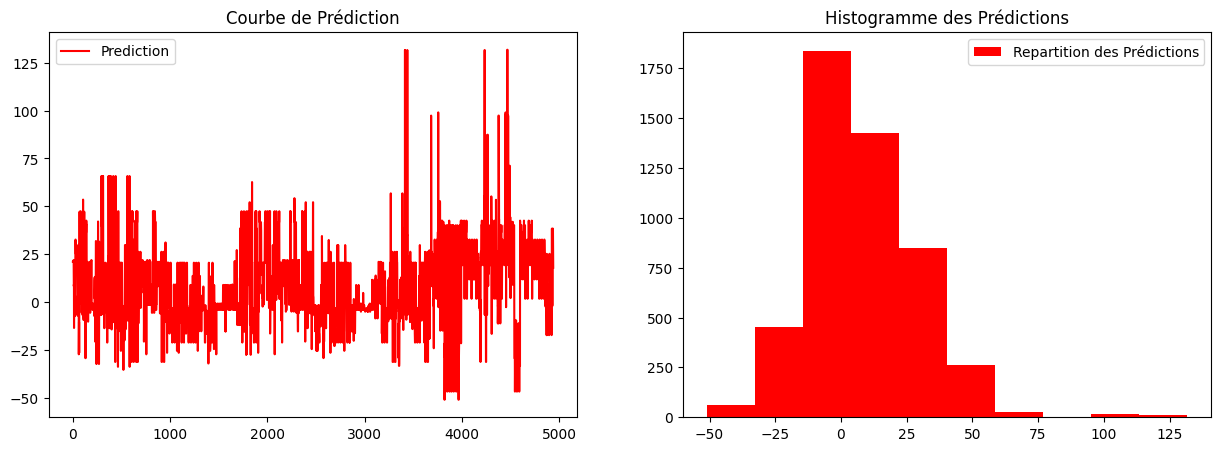

In [130]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(y_test_pred, label="Prediction", color='r')
axs[0].set_title("Courbe de Prédiction")
axs[0].legend()

axs[1].hist(y_test_pred, label="Repartition des Prédictions", color='r')
axs[1].set_title("Histogramme des Prédictions")
axs[1].legend()

plt.show()

# 0,5046671076593005

## BaggingRegressor

In [123]:
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

model = BaggingRegressor()
pipeline = make_pipeline(StandardScaler(), model)

cv_10_scores = cross_val_score(pipeline, X_train_fill0, y_train, cv=10, scoring=weighted_accuracy_scorer).round(4)
print(f"10 cv scores: {cv_10_scores}")

mean_cv_10_score = cv_10_scores.mean().round(4)
print("Mean Cross-Validation Weighted Accuracy:", mean_cv_10_score)



k = 10
tscv = TimeSeriesSplit(n_splits=k)

tscv_scores = cross_val_score(pipeline, X_train_fill0, y_train, cv=tscv, scoring=weighted_accuracy_scorer).round(4)
print(f"\ntscv scores: {tscv_scores}")

mean_tscv_score = tscv_scores.mean().round(4)
print("Mean Cross-Validation Weighted Accuracy:", mean_tscv_score)



pipeline.fit(X_train_fill0, y_train)
predictions = pipeline.predict(X_train_fill0)

test_weighted_accuracy = round(weighted_accuracy(y_train, predictions), 4)
print("\nOverfitted Weighted Accuracy:", test_weighted_accuracy)

y_test_pred = pipeline.predict(X_test_fill0)

10 cv scores: [0.6196 0.5151 0.3546 0.5187 0.5248 0.5744 0.5273 0.4231 0.5563 0.4232]
Mean Cross-Validation Weighted Accuracy: 0.5037

tscv scores: [0.4256 0.5879 0.4424 0.5456 0.4219 0.5895 0.4161 0.5189 0.3541 0.5319]
Mean Cross-Validation Weighted Accuracy: 0.4834

Overfitted Weighted Accuracy: 0.9852


# 2) test de différents modèles pour X_train_drop

## XBGBoost Regressor

In [133]:
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

model = xgb.XGBRegressor()
pipeline = make_pipeline(StandardScaler(), model)

cv_10_scores = cross_val_score(pipeline, X_train_drop, y_train_drop, cv=10, scoring=weighted_accuracy_scorer).round(4)
print(f"10 cv scores: {cv_10_scores}")

mean_cv_10_score = cv_10_scores.mean().round(4)
print("Mean Cross-Validation Weighted Accuracy:", mean_cv_10_score)



k = 10
tscv = TimeSeriesSplit(n_splits=k)

tscv_scores = cross_val_score(pipeline, X_train_drop, y_train_drop, cv=tscv, scoring=weighted_accuracy_scorer).round(4)
print(f"\ntscv scores: {tscv_scores}")

mean_tscv_score = tscv_scores.mean().round(4)
print("Mean Cross-Validation Weighted Accuracy:", mean_tscv_score)



pipeline.fit(X_train_drop, y_train_drop)
predictions = pipeline.predict(X_train_drop)

test_weighted_accuracy = round(weighted_accuracy(y_train_drop, predictions), 4)
print("\nOverfitted Weighted Accuracy:", test_weighted_accuracy)

y_test_pred = pipeline.predict(X_test_fill0)

10 cv scores: [0.4854 0.4641 0.6085 0.6844 0.64   0.4921 0.5766 0.46   0.7435 0.7773]
Mean Cross-Validation Weighted Accuracy: 0.5932

tscv scores: [0.5926 0.1709 0.3214 0.6023 0.5573 0.6642 0.3753 0.7555 0.5888 0.7944]
Mean Cross-Validation Weighted Accuracy: 0.5423

Overfitted Weighted Accuracy: 0.9978


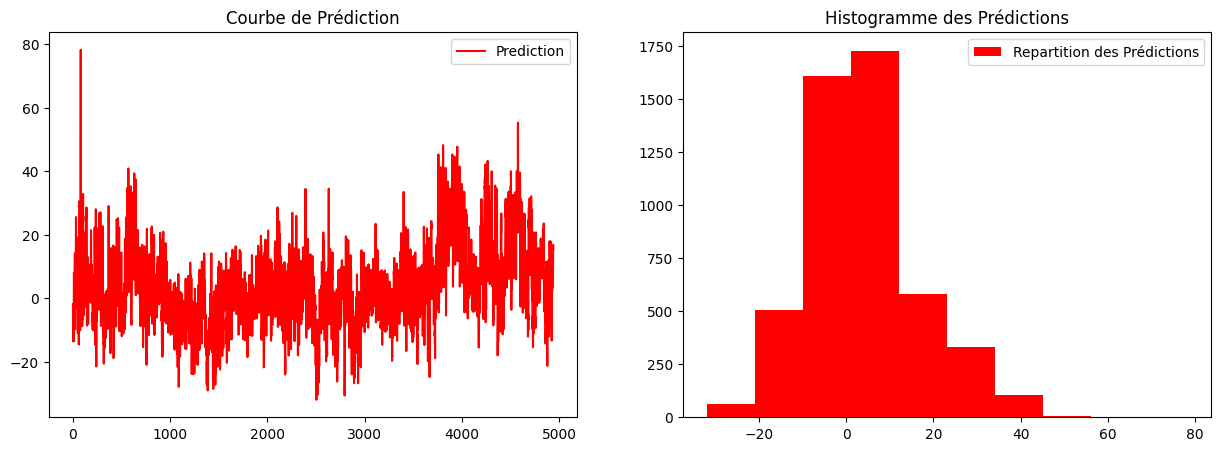

In [136]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(y_test_pred, label="Prediction", color='r')
axs[0].set_title("Courbe de Prédiction")
axs[0].legend()

axs[1].hist(y_test_pred, label="Repartition des Prédictions", color='r')
axs[1].set_title("Histogramme des Prédictions")
axs[1].legend()

plt.show()

# 0,5301143605732976

## AdaBoostRegressor

In [137]:
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

model = AdaBoostRegressor()
pipeline = make_pipeline(StandardScaler(), model)

cv_10_scores = cross_val_score(pipeline, X_train_drop, y_train_drop, cv=10, scoring=weighted_accuracy_scorer).round(4)
print(f"10 cv scores: {cv_10_scores}")

mean_cv_10_score = cv_10_scores.mean().round(4)
print("Mean Cross-Validation Weighted Accuracy:", mean_cv_10_score)



k = 10
tscv = TimeSeriesSplit(n_splits=k)

tscv_scores = cross_val_score(pipeline, X_train_drop, y_train_drop, cv=tscv, scoring=weighted_accuracy_scorer).round(4)
print(f"\ntscv scores: {tscv_scores}")

mean_tscv_score = tscv_scores.mean().round(4)
print("Mean Cross-Validation Weighted Accuracy:", mean_tscv_score)



pipeline.fit(X_train_drop, y_train_drop)
predictions = pipeline.predict(X_train_drop)

test_weighted_accuracy = round(weighted_accuracy(y_train_drop, predictions), 4)
print("\nOverfitted Weighted Accuracy:", test_weighted_accuracy)

y_test_pred = pipeline.predict(X_test_fill0)

10 cv scores: [0.3604 0.3223 0.8383 0.5832 0.6562 0.4213 0.5422 0.9447 0.6555 0.7111]
Mean Cross-Validation Weighted Accuracy: 0.6035

tscv scores: [0.4055 0.0975 0.2233 0.5015 0.6418 0.6955 0.3069 0.8245 0.6779 0.6758]
Mean Cross-Validation Weighted Accuracy: 0.505

Overfitted Weighted Accuracy: 0.756


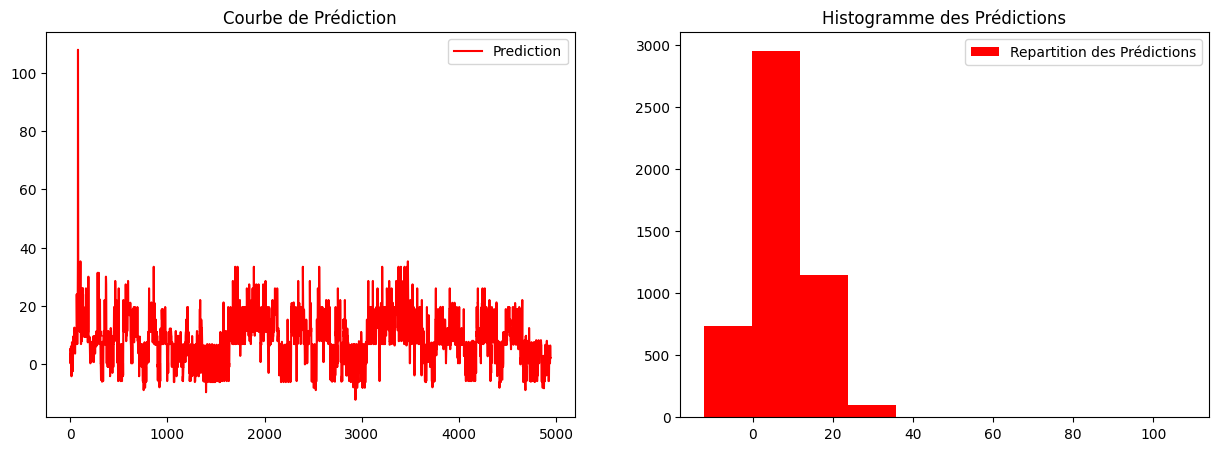

In [140]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(y_test_pred, label="Prediction", color='r')
axs[0].set_title("Courbe de Prédiction")
axs[0].legend()

axs[1].hist(y_test_pred, label="Repartition des Prédictions", color='r')
axs[1].set_title("Histogramme des Prédictions")
axs[1].legend()

plt.show()

# 0,553515973487837

## CatBoostRegressor

In [142]:
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

model = CatBoostRegressor(verbose=0)
pipeline = make_pipeline(StandardScaler(), model)

cv_10_scores = cross_val_score(pipeline, X_train_drop, y_train_drop, cv=10, scoring=weighted_accuracy_scorer).round(4)
print(f"10 cv scores: {cv_10_scores}")

mean_cv_10_score = cv_10_scores.mean().round(4)
print("Mean Cross-Validation Weighted Accuracy:", mean_cv_10_score)



k = 10
tscv = TimeSeriesSplit(n_splits=k)

tscv_scores = cross_val_score(pipeline, X_train_drop, y_train_drop, cv=tscv, scoring=weighted_accuracy_scorer).round(4)
print(f"\ntscv scores: {tscv_scores}")

mean_tscv_score = tscv_scores.mean().round(4)
print("Mean Cross-Validation Weighted Accuracy:", mean_tscv_score)



pipeline.fit(X_train_drop, y_train_drop)
predictions = pipeline.predict(X_train_drop)

test_weighted_accuracy = round(weighted_accuracy(y_train_drop, predictions), 4)
print("\nOverfitted Weighted Accuracy:", test_weighted_accuracy)

y_test_pred = pipeline.predict(X_test_fill0)

10 cv scores: [0.6735 0.4993 0.7159 0.7427 0.5578 0.4696 0.4947 0.6086 0.7589 0.8699]
Mean Cross-Validation Weighted Accuracy: 0.6391

tscv scores: [0.4959 0.331  0.267  0.564  0.5813 0.7491 0.5228 0.7365 0.6178 0.8305]
Mean Cross-Validation Weighted Accuracy: 0.5696

Overfitted Weighted Accuracy: 0.9776


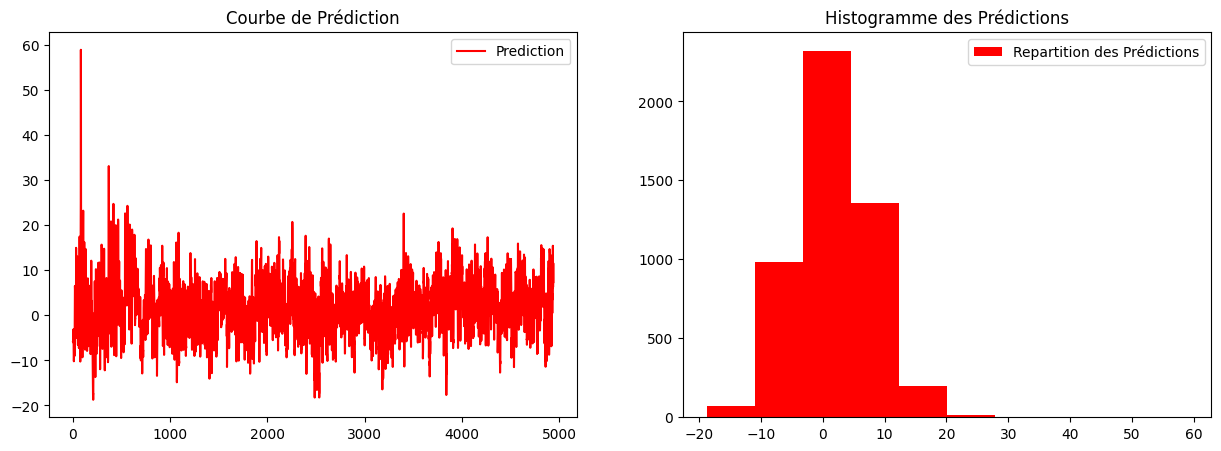

In [145]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(y_test_pred, label="Prediction", color='r')
axs[0].set_title("Courbe de Prédiction")
axs[0].legend()

axs[1].hist(y_test_pred, label="Repartition des Prédictions", color='r')
axs[1].set_title("Histogramme des Prédictions")
axs[1].legend()

plt.show()

# 0,5417546316618331